In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim

# Setting random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Loading the dataset
data = pd.read_csv("balanced_biased_resume_dataset.csv")

# Storing Label Encodings
rencoder = LabelEncoder()
gencoder = LabelEncoder()
data['Race'] = rencoder.fit_transform(data['Race'])
data['Gender'] = gencoder.fit_transform(data['Gender'])

# Performing Reverse Mapping
rmapping = dict(zip(range(len(rencoder.classes_)), rencoder.classes_))
gmapping = dict(zip(range(len(gencoder.classes_)), gencoder.classes_))
data['Age'] = data['Age'].astype(float)

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).logits

# Initializing the Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class ResumeDataset(Dataset):
    def __init__(self, data):
        self.texts = data['Resume Text'].tolist()
        self.labels = data['Shortlisted'].tolist()
        self.demographics = data[['Race', 'Gender', 'Age']].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        demographics = torch.tensor(self.demographics[idx], dtype=torch.float)
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'demographics': demographics}

# Splitting data for train and validation
trdata, vdata = train_test_split(data, test_size=0.2, random_state=seed)
vdataset = ResumeDataset(vdata)
vloader = DataLoader(vdataset, batch_size=16)

# Reloading the best model from system
bertm = torch.load("best_bertm_full.pth")

# Evaluating BERT with validation set
bertm.eval()
ytrue, ypred = [], []
alldemo = []
for batch in vloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    demographics = batch['demographics'].cpu().numpy()
    with torch.no_grad():
        ouTrPuts = bertm(input_ids, attention_mask)
        predictions = torch.argmax(ouTrPuts, dim=1)
    ytrue.extend(labels.cpu().numpy())
    ypred.extend(predictions.cpu().numpy())
    alldemo.extend(demographics)

# Calculating classification Metrics
print(classification_report(ytrue, ypred))

roc = roc_auc_score(ytrue, ypred)
f1 = f1_score(ytrue, ypred)
print(f"AUC-ROC: {roc}")
print(f"F1 Score: {f1}")

# Calculating Disparate Impact Metric
def calculateDI(ytrue, ypred, demographics):
    demographics = np.array(demographics)
    uqcomb = np.unique(demographics, axis=0)
    selrates = {}
    
    for combo in uqcomb:
        mask = np.all(demographics == combo, axis=1)
        toTrPop = np.sum(mask)
        selpop = np.sum(np.array(ypred)[mask] == 1)

        if toTrPop > 0:
            selrates[tuple(combo)] = selpop / toTrPop

    for combo, rate in selrates.items():
        rname = rmapping.get(int(combo[0]), "Unknown")
        gname = gmapping.get(int(combo[1]), "Unknown")
        print(f"Selection Rate for Race: {rname}, Gender: {gname}, Age: {combo[2]}: {rate:.4f}")

    for combo, rate in selrates.items():
        for otrcombo, otrrate in selrates.items():
            if otrrate > 0:
                disparity = rate / otrrate
                race1, gender1, age1 = combo
                race2, gender2, age2 = otrcombo

                print(f"Disparate Impact between Race {rmapping.get(race1)}, Gender {gmapping.get(gender1)}, Age {age1} "
                      f"and Race {rmapping.get(race2)}, Gender {gmapping.get(gender2)}, Age {age2}: {disparity:.4f}")


calculateDI(ytrue, ypred, alldemo)

# Calculating Fairness Metrics Calculation
def calculateFM(ytrue, ypred, demographics):
    demographics = np.array(demographics)
    uqcomb = np.unique(demographics, axis=0)

    metrics = {}

    for combo in uqcomb:
        mask = np.all(demographics == combo, axis=1)
        TrP = np.sum((np.array(ytrue)[mask] == 1) & (np.array(ypred)[mask] == 1))
        ToP = np.sum(mask)

        if ToP > 0:
            rname = rmapping.get(int(combo[0]), "Unknown")
            gname = gmapping.get(int(combo[1]), "Unknown")
            combokey = f"Race: {rname}, Gender: {gname}, Age: {combo[2]}"
            metrics[f"{combokey} True Positive Rate"] = TrP / ToP

    print("Intersectional Fairness Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

calculateFM(ytrue, ypred, alldemo)

# Calculating Equal Opportunity Metric
def calculateEO(ytrue, ypred, demographics):
    demographics = np.array(demographics)
    uqcomb = np.unique(demographics, axis=0)
    TrPr = {}

    for combo in uqcomb:
        mask = np.all(demographics == combo, axis=1)
        TrP = np.sum((np.array(ytrue)[mask] == 1) & (np.array(ypred)[mask] == 1))
        ToP = np.sum(np.array(ytrue)[mask] == 1)

        if ToP > 0:
            TrPr[tuple(combo)] = TrP / ToP

    for combo, rate in TrPr.items():
        rname = rmapping.get(int(combo[0]), "Unknown")
        gname = gmapping.get(int(combo[1]), "Unknown")
        age = combo[2]
        print(f"Equal Opportunity (TrPR) for Race: {rname}, Gender: {gname}, Age: {age:.2f}: {rate:.4f}")

calculateEO(ytrue, ypred, alldemo)

/home/stu1/s7/sp7289/miniconda3/envs/idai610/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/stu1/s7/sp7289/miniconda3/envs/idai610/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_3176951/1935115822.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       216
           1       0.84      0.78      0.81       184

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

AUC-ROC: 0.8288043478260869
F1 Score: 0.8112676056338028
Selection Rate for Race: Asian, Gender: Female, Age: 22.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 23.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 24.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 25.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 27.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 29.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 31.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 32.0: 1.0000
Selection Rate for Race: Asian, Gender: Female, Age: 34.0: 1.0000
Selection Rate for Rac

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



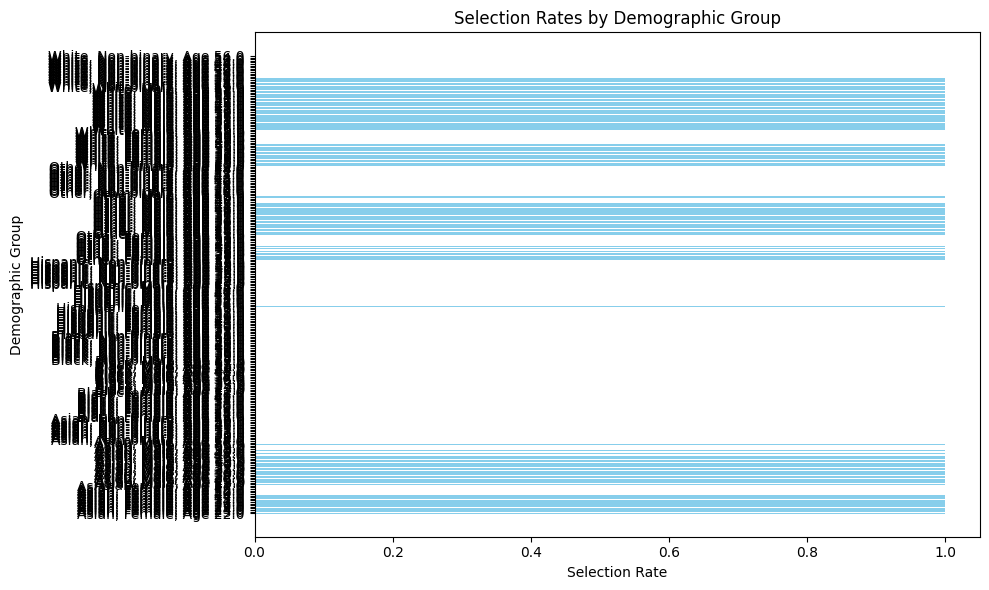

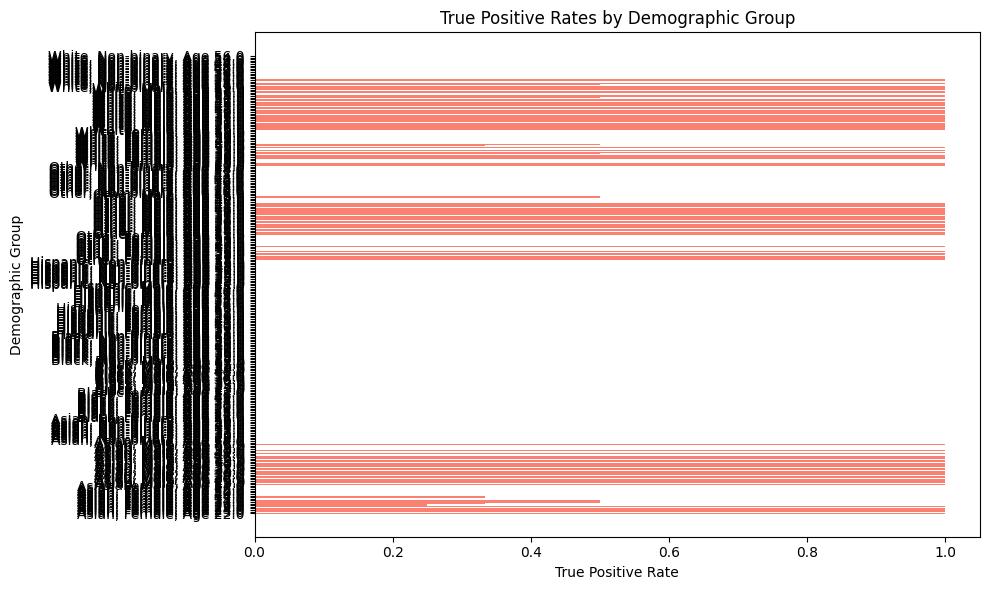

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting Selection Rates
selrates = {}
uqcomb = np.unique(np.array(alldemo), axis=0)

for combo in uqcomb:
    mask = np.all(np.array(alldemo) == combo, axis=1)
    toTrPop = np.sum(mask)
    selpop = np.sum(np.array(ypred)[mask] == 1)

    if toTrPop > 0:
        selrates[tuple(combo)] = selpop / toTrPop

# Preparing Data for Plot
plotd = []
for combo, rate in selrates.items():
    rname = rmapping.get(int(combo[0]), "Unknown")
    gname = gmapping.get(int(combo[1]), "Unknown")
    age = combo[2]
    label = f"{rname}, {gname}, Age {age}"
    plotd.append((label, rate))

labels, rates = zip(*plotd)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(labels, rates, color='skyblue')
plt.xlabel("Selection Rate")
plt.ylabel("Demographic Group")
plt.title("Selection Rates by Demographic Group")
plt.tight_layout()
plt.show()

metrics = {}
for combo in uqcomb:
    mask = np.all(np.array(alldemo) == combo, axis=1)
    TrP = np.sum((np.array(ytrue)[mask] == 1) & (np.array(ypred)[mask] == 1))
    ToP = np.sum(mask)

    if ToP > 0:
        rname = rmapping.get(int(combo[0]), "Unknown")
        gname = gmapping.get(int(combo[1]), "Unknown")
        combokey = f"{rname}, {gname}, Age {combo[2]}"
        metrics[combokey] = TrP / ToP

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(list(metrics.keys()), list(metrics.values()), color='salmon')
plt.xlabel("True Positive Rate")
plt.ylabel("Demographic Group")
plt.title("True Positive Rates by Demographic Group")
plt.tight_layout()
plt.show()


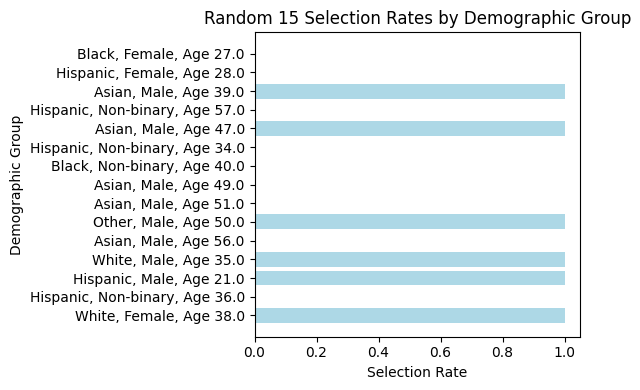

('White, Female, Age 38.0', np.float64(1.0))
('Hispanic, Non-binary, Age 36.0', np.float64(0.0))
('Hispanic, Male, Age 21.0', np.float64(1.0))
('White, Male, Age 35.0', np.float64(1.0))
('Asian, Male, Age 56.0', np.float64(0.0))
('Other, Male, Age 50.0', np.float64(1.0))
('Asian, Male, Age 51.0', np.float64(0.0))
('Asian, Male, Age 49.0', np.float64(0.0))
('Black, Non-binary, Age 40.0', np.float64(0.0))
('Hispanic, Non-binary, Age 34.0', np.float64(0.0))
('Asian, Male, Age 47.0', np.float64(1.0))
('Hispanic, Non-binary, Age 57.0', np.float64(0.0))
('Asian, Male, Age 39.0', np.float64(1.0))
('Hispanic, Female, Age 28.0', np.float64(0.0))
('Black, Female, Age 27.0', np.float64(0.0))


In [3]:
import random
# Setting random seed for reproducibility
random.seed(63)

random_plotd = random.sample(plotd, 15)

# Adjusting figure size
plt.figure(figsize=(6, 4))

# Extracting labels and rates from the selected data
labels, rates = zip(*random_plotd)

# Plotting the random 15 demographic groups
plt.barh(labels, rates, color='lightblue')

# Adding title and labels
plt.title('Random 15 Selection Rates by Demographic Group')
plt.xlabel('Selection Rate')
plt.ylabel('Demographic Group')

# Improving layout for better readability
plt.tight_layout()

# Displaying the plot
plt.show()

for group in random_plotd:
    print(group)


In [4]:
# Preparing Disparity Matrix
dmatrix = []
glabels = []

for combo in uqcomb:
    row = []
    for otrcombo in uqcomb:
        rate = selrates.get(tuple(combo), 0)
        otrrate = selrates.get(tuple(otrcombo), 0)
        disparity = rate / otrrate if otrrate > 0 else 0
        row.append(disparity)
    dmatrix.append(row)
    glabels.append(f"{rmapping[int(combo[0])]}, {gmapping[int(combo[1])]}, Age {combo[2]}")


/tmp/ipykernel_3176951/3119552491.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_df, x="Group", y="Disparity", hue="Compared Group", ci=None)


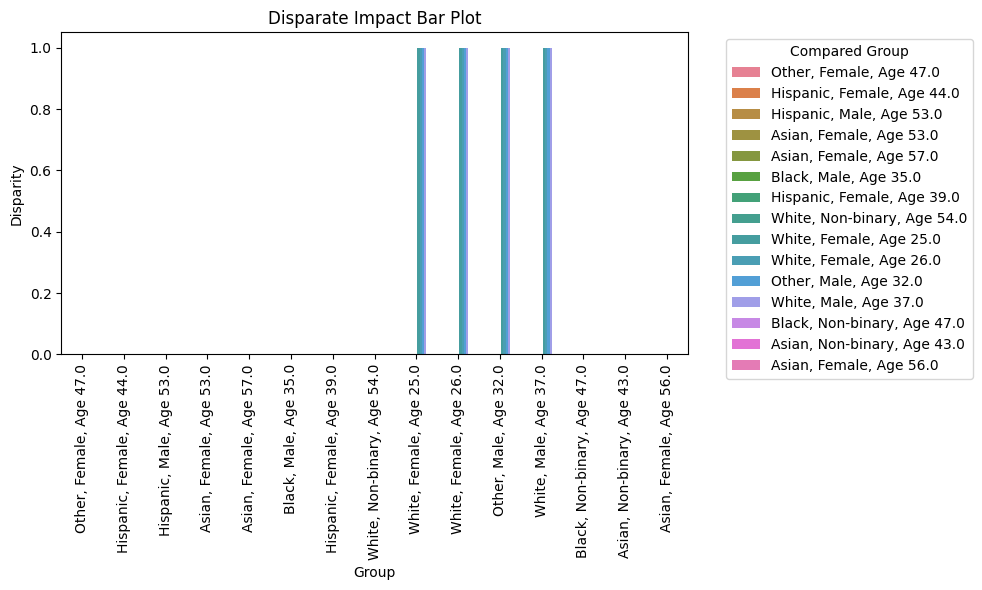

In [5]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

num_groups = min(15, len(dmatrix))  
random_indices = random.sample(range(len(dmatrix)), num_groups)

# Subsetting the matrix
random_dmatrix = [[dmatrix[i][j] for j in random_indices] for i in random_indices]
# Subsetting the labels
random_glabels = [glabels[i] for i in random_indices]

# Converting the disparity matrix into a DataFrame
df = pd.DataFrame(random_dmatrix, index=random_glabels, columns=random_glabels)

# Preparing the data for bar plot
melted_df = df.reset_index().melt(id_vars='index', var_name='Compared Group', value_name='Disparity')
melted_df = melted_df.rename(columns={"index": "Group"})

# Plotting as a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Group", y="Disparity", hue="Compared Group", ci=None)

# Title and labels
plt.title("Disparate Impact Bar Plot")
plt.xticks(rotation=90)
plt.xlabel("Group")
plt.ylabel("Disparity")
plt.legend(title="Compared Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


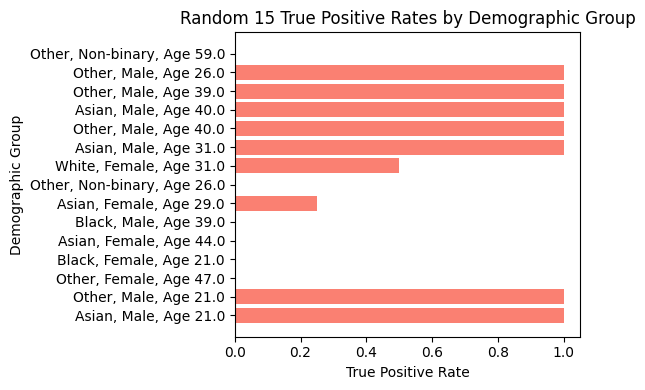

In [6]:
import matplotlib.pyplot as plt
import random

# Selecting a random sample of 15 demographic groups
random50 = random.sample(list(metrics.items()), 15)

# Unpacking the selected values
randlbls, randtpr = zip(*random50)

# Plotting
plt.figure(figsize=(6, 4))
plt.barh(randlbls, randtpr, color='salmon')
plt.xlabel("True Positive Rate")
plt.ylabel("Demographic Group")
plt.title("Random 15 True Positive Rates by Demographic Group")
plt.tight_layout()
plt.show()


In [7]:
def calculateFMP(ytrue, ypred, demographics):
    demographics = np.array(demographics)
    uqcomb = np.unique(demographics, axis=0)

    metrics = {}

    for combo in uqcomb:
        mask = np.all(demographics == combo, axis=1)
        TrP = np.sum((np.array(ytrue)[mask] == 1) & (np.array(ypred)[mask] == 1))
        ToP = np.sum(mask)

        if ToP > 0:  # Skip if there's no data
            rname = rmapping.get(int(combo[0]))
            gname = gmapping.get(int(combo[1]))
            combokey = f"Race: {rname}, Gender: {gname}, Age: {combo[2]}"
            metrics[f"{combokey} True Positive Rate"] = TrP / ToP

    print("Intersectional Fairness Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


# Initializing GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 256),  # Increased complexity
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        
    def forward(self, x):
        return self.fc(x)
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 128),  # Adjusted structure
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fc(x)

# Training GAN architecture
generator = Generator()
discriminator = Discriminator()

/tmp/ipykernel_3176951/1614902287.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  perturbdemo = generator(torch.tensor(alldemo).float()).cpu().detach().numpy()


Intersectional Fairness Metrics:
Race: Asian, Gender: None, Age: -0.8622184991836548 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.8508305549621582 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.8334910869598389 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.8948621153831482 True Positive Rate: 1.0000
Race: Asian, Gender: None, Age: -0.8219519853591919 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.8834735751152039 True Positive Rate: 1.0000
Race: Asian, Gender: None, Age: -0.8280528783798218 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.8442718982696533 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.7946021556854248 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.786780834197998 True Positive Rate: 0.0000
Race: Asian, Gender: None, Age: -0.872084379196167 True Positive Rate: 1.0000
Race: Asian, Gender: None, Age: -0.8532441854476929 True Positive Rate: 0.0000
Race: Asian, Gender: 

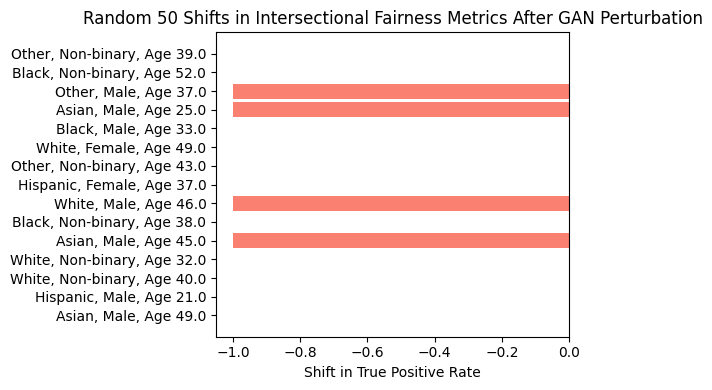

In [8]:
perturbdemo = generator(torch.tensor(alldemo).float()).cpu().detach().numpy()

# Evaluating fairness metrics after perturbation
perturbFM = calculateFMP(ytrue, ypred, perturbdemo)

# Visualizing Shifts in Fairness Metrics
shifts = {}
for key, orgval in metrics.items():
    perturbval = perturbFM.get(key, 0)
    shift = perturbval - orgval
    shifts[key] = shift

random_shifts = random.sample(list(shifts.items()), 15)

# Preparing the data for visualization
categories, values = zip(*random_shifts)

# Plotting the first 15 random shifts
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(categories, values, color='salmon')
ax.set_xlabel("Shift in True Positive Rate")
ax.set_title("Random 50 Shifts in Intersectional Fairness Metrics After GAN Perturbation")
plt.tight_layout()
plt.show()

